# Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdmn
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.balanced_image import BalancedImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model, load_model
import csv
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from keras.layers import Input
import multiprocessing
from joblib import Parallel, delayed
from skimage import io
from IPython.display import clear_output
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')


# Global variables
NB_SES_CLASSES = 5
PATIENCE_BEFORE_STOPPING = 5
PATIENCE_BEFORE_LOWERING_LR = 1
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 16
IMG_SIZE = (400, 400)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 10
INITIAL_LR = 1e-4
CPU_COUNT = multiprocessing.cpu_count()
CPU_FRAC = .7
CPU_USE = int(CPU_FRAC*CPU_COUNT)
ADRIAN_ALBERT_THRESHOLD = .25
INSEE_AREA = 200*200
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
from keras.applications.resnet50 import ResNet50
import efficientnet 
import numpy as np
from keras import backend as K

def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem
    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])
    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0
    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

model = ResNet50()
print(get_model_memory_usage(16,model))
print(get_model_memory_usage(16,efficientnet.EfficientNetB0()))
print(get_model_memory_usage(16,efficientnet.EfficientNetB3()))
print(get_model_memory_usage(16,efficientnet.EfficientNetB5()))

In [1]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def top_k_accuracy(y_true, y_pred,val_k):
    """ UNTESTED """
    topk_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=val_k)
    topk_acc.__name__ = 'topk_acc'
    return topk_acc(y_true, y_pred)

def neigh_k_accuracy(y_true, y_pred, val_k):
    """ UNTESTED """
    kernel = K.ones((1,val_k),)
    classes_pred = K.conv1d(y_pred,kernel,padding='same')
    true_positives = K.sum(K.round(K.clip(y_true * classes_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    return(true_positives / (predicted_positives + K.epsilon()))  

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
-    Computes the precision, a metric for multi-label classification of 
-    how many selected items are relevant. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
-    Only computes a batch-wise average of recall. 
-    Computes the recall, a metric for multi-label classification of 
-    how many relevant items are selected. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 
    """Computes the F score.  
-    The F score is the weighted harmonic mean of precision and recall. 
-    Here it is only computed as a batch-wise average, not globally. 
-    This is useful for multi-label classification, where input samples can be 
-    classified as sets of labels. By only using accuracy (precision) a model 
-    would achieve a perfect score by simply assigning every class to every 
-    input. In order to avoid this, a metric should penalize incorrect class 
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0) 
-    computes this, as a weighted mean of the proportion of correct class 
-    assignments vs. the proportion of incorrect class assignments.  
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning 
-    correct classes becomes more important, and with beta > 1 the metric is 
-    instead weighted towards penalizing incorrect class assignments. 
-    """ 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    # If there are no true positives, fix the F score at 0 like sklearn. 
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 

        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    """Computes the f-measure, the harmonic mean of precision and recall. 
    Here it is only computed as a batch-wise average, not globally. 
    """ 
    return fbeta_score(y_true, y_pred, beta=1) 

def my_preprocessor(image):
    image = np.array(image)
    image = (image - np.min(image))/(.1 + np.max(image)-np.min(image))
    return image

def chunks(arr, nb_splits):
    #Yield successive n-sized chunks from l.
    order = np.linspace(start=0,stop=len(arr),num=nb_splits + 1)
    for i in range(len(order)-1):
        yield arr[int(order[i]):int(order[i+1])]

def parallel_folder_extraction(im_dir,null_thresh):
    images = []
    s = ""
    print
    for it,path in enumerate(im_dir):
        if it % 100 == 0:
            perc = 100*(it+0.0)/len(im_dir)
            s += "%.2f ... "%perc
            print(s)
        image = io.imread(AERIAL_DIR + path)
        if  100*(image==0).sum()/image.size > null_thresh :
            images.append((path,False))
        else:
            images.append((path,True))
    clear_output()
    return images

def parallel_make_dataset(im_data, null_thresh = 1):
    nb_images = len(im_data)
    pre_full = Parallel(n_jobs=CPU_USE)(
        delayed(parallel_folder_extraction)(im_arr,null_thresh=null_thresh)
        for im_arr in tqdmn(chunks(im_data,CPU_USE)))
    return [data for pre in pre_full for data in pre]


def consolidate_UA_classes(gdf, class_col='ITEM'):
	consolidate_classes = {
        "arable land (annual crops)":"agricultural + semi-natural areas + wetlands",
        "permanent crops (vineyards, fruit trees, olive groves)":"agricultural + semi-natural areas + wetlands",
        "pastures":"agricultural + semi-natural areas + wetlands",
        "water bodies":"water",
        "complex and mixed cultivation patterns":"agricultural + semi-natural areas + wetlands",
        "orchards":"agricultural + semi-natural areas + wetlands",
	    "continuous urban fabric (s.l. > 80%)":"very high density urban fabric",
	     "discontinuous dense urban fabric (s.l. 50% - 80%)":"high density urban fabric",
	     "discontinuous medium density urban fabric (s.l. 30% - 50%)":"medium density urban fabric",
	     "discontinuous low density urban fabric (s.l. 10% - 30%)":"low density urban fabric",
	     "discontinuous very low density urban fabric (s.l. < 10%)":"very low density urban fabric"
	}
	gdf[class_col] = gdf[class_col].apply(
	    lambda x: consolidate_classes[x] if x in consolidate_classes else x)

	include_classes = ["green urban areas", 
	                   "forests",
	                   "agricultural + semi-natural areas + wetlands",
	                   "very high density urban fabric", 
                       "high density urban fabric", 
	                   "medium density urban fabric", 
	                   "low density urban fabric",
                       "very low density urban fabric",
                       "water",
	                   "sports and leisure facilities",
	                   "industrial, commercial, public, military and private units"]
	gdf = gdf[gdf[class_col].isin(include_classes)]
	return gdf

In [3]:
from efficientnet import EfficientNetB3 as EfficientNet
model = EfficientNet(weights='imagenet',input_shape=(800,800,3),include_top=False)


Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [ ]:
from efficientnet import EfficientNetB3 as EfficientNet

print("Defining and Compiling Model")
base_model = EfficientNet(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE,)
x=GlobalAveragePooling2D()(base_model.output)
ses_predictions = Dense(NB_SES_CLASSES, activation='softmax',name="ses_output")(x)
ua_predictions = Dense(NB_UA_CLASS, activation='softmax',name="ua_output")(x)

# this is the model we will train
model = Model(inputs=base_model.input,outputs=[ses_predictions, ua_predictions]) #outputs=predictions)

# Aerial Imagery

In [ ]:
print("Loading INSEE SES Dataset")
pre_dic = pd.read_csv(AERIAL_DIR + "../census_data/squares_to_ses.csv" )
pre_dic.dropna(subset=["income"],inplace=True)

print("Loading image")
image_files = [os.path.join(inter_sat_dir,im_file) for inter_sat_dir in tqdmn(os.listdir(AERIAL_DIR) )
               for im_file in os.listdir(AERIAL_DIR + inter_sat_dir) if im_file.endswith(".png")]

im_df = pd.DataFrame()
im_df["path2im"] = image_files
im_df["idINSPIRE"] = [k.split("/")[-1].split(".")[0].split("_")[-1] for k in image_files]
full_im_df_all = pd.merge(pre_dic,im_df,on="idINSPIRE")

In [ ]:
print("Filtering Void Datasets")
check_void = parallel_make_dataset(full_im_df_all.path2im)
void_df = pd.DataFrame(check_void,columns=["path2im","non_void"])
full_im_df_all = pd.merge(full_im_df_all,void_df,on="path2im")
full_im_df = full_im_df_all[full_im_df_all.non_void]
full_im_df.reset_index(drop=True,inplace=True)

In [ ]:
full_im_df_all[["idINSPIRE","non_void"]].to_csv(AERIAL_DIR + "void_data.csv",index=False)

In [ ]:
print("Loading UA Classes")
insee2ua = pd.read_csv(UA_DIR + "../insee_to_max_urban_class_data.csv",sep=";")
treat_class = lambda x :x.lower()\
     .replace(":","")\
     .replace("  "," ")\
     .replace("…","...")\
     .replace(", ("," (")\
     .replace("vegetations","vegetation")

insee2ua["right_class"] = [treat_class(x) for x in insee2ua["right_class"]]
insee2ua = consolidate_UA_classes(insee2ua,"right_class")
insee2ua = insee2ua[insee2ua.match_bool > (ADRIAN_ALBERT_THRESHOLD*INSEE_AREA)] #contain at least 25% of associated ground truth polygon
full_im_df_ua = pd.merge(full_im_df,insee2ua[["right_class","idINSPIRE"]],on="idINSPIRE")

print("Generating Income Classes")
income = full_im_df_ua.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_SES_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_SES_CLASSES
full_im_df_ua["treated_income"] = [ str(y-1) for y in x_to_class ]

print("Generating Income+UA Classes")
full_im_df_ua["proxy_class"] = [(x,y) for x,y in full_im_df_ua[["treated_income","right_class"]].values]

In [ ]:
full_im_df_all.head()

In [ ]:
im_test

In [ ]:
im_test = AERIAL_DIR + full_im_df_all.path2im.sample(1).iloc[0]
I = io.imread(im_test)
plt.figure(figsize=(15,15));
plt.imshow(I);

# Bundling data by city

In [1]:
# Global paths
BASE_DIR = "/warehouse/COMPLEXNET/jlevyabi/"
SAT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
CENSUS_DIR = BASE_DIR + 'REPLICATE_LINGSES/data_files/census_data/'
UA_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
BASE_AERDIR = BASE_DIR + "SATELSES/"
AERIAL_DIR= BASE_AERDIR + "equirect_proj_test/cnes/data_files/outputs/AERIAL_esa_URBAN_ATLAS_FR/"
MODEL_OUTPUT_DIR = BASE_AERDIR + "equirect_proj_test/cnes/data_files/outputs/model_data/resnet50_keras/income/"

import sys
sys.path.append(BASE_DIR + "SATELSES/equirect_proj_test/cnes/python_files/satellite/")
from generate_fr_ua_vhr_data import generate_car_census_data
# Global variables
NB_SES_CLASSES = 5
PATIENCE_BEFORE_STOPPING = 5
PATIENCE_BEFORE_LOWERING_LR = 1
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 16
IMG_SIZE = (400, 400)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 10
INITIAL_LR = 1e-4
ADRIAN_ALBERT_THRESHOLD = .25
INSEE_AREA = 200*200


In [2]:
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import os
from tqdm import tqdm_notebook as tqdmn
import numpy as np
import csv
from sklearn.metrics import confusion_matrix, classification_report
from time import time
import multiprocessing
from joblib import Parallel, delayed
from skimage import io
from IPython.display import clear_output
import matplotlib.pyplot as plt
import glob
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

In [ ]:
idINSPIRE2GEOM = generate_car_census_data()[["idINSPIRE","geometry"]]

idINSPIRE2UA = pd.read_csv(UA_DIR + "../insee_to_max_urban_class_data.csv",sep=";")
treat_class = lambda x :x.lower()\
     .replace(":","")\
     .replace("  "," ")\
     .replace("…","...")\
     .replace(", ("," (")\
     .replace("vegetations","vegetation")

idINSPIRE2UA["right_class"] = [treat_class(x) for x in idINSPIRE2UA["right_class"]]

idINSPIRE2UA = consolidate_UA_classes(idINSPIRE2UA,"right_class")

idINSPIRE2UA = idINSPIRE2UA[idINSPIRE2UA.match_bool > (ADRIAN_ALBERT_THRESHOLD*INSEE_AREA)] #contain at least 25% of associated ground truth polygon

idINSPIRE2SES = pd.read_csv(AERIAL_DIR + "../census_data/squares_to_ses.csv")
idINSPIRE2SES.dropna(subset=["income"],inplace=True)
income = idINSPIRE2SES.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_SES_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_SES_CLASSES
idINSPIRE2SES["treated_income"] = [ str(y-1) for y in x_to_class ]

idINSPIRE2VOID = pd.read_csv(AERIAL_DIR + "void_data.csv")

idINSPIRE2IMG = pd.DataFrame(
    [(im_file.split(".")[0].split("_")[-1],os.path.join(inter_sat_dir,im_file))
     for inter_sat_dir in os.listdir(AERIAL_DIR) if not inter_sat_dir.endswith(".csv")
     for im_file in os.listdir(AERIAL_DIR + inter_sat_dir) if im_file.endswith(".png")],
    columns = ["idINSPIRE","path2im"])

idINSPIRE_full = gpd.GeoDataFrame(
    reduce(lambda left,right: pd.merge(left,right,on=['idINSPIRE']),
           [idINSPIRE2GEOM,idINSPIRE2UA,idINSPIRE2SES,idINSPIRE2VOID,idINSPIRE2IMG]))
idINSPIRE_full.crs = idINSPIRE2GEOM.crs
idINSPIRE_full = idINSPIRE_full[idINSPIRE_full.non_void]

In [ ]:
UA_POLY_DIR = glob.glob(UA_DIR + "**/Shapefiles/*UA2012_Boundary.shp")
CITY_POLY_DIR = glob.glob(UA_DIR + "**/Shapefiles/*CityBoundary.shp")
UA_COLS = ["AREA_KM2","COUNTRY","FUA_NAME","URBAN_KM2","URBAN_RATE","LU12_AVAIL","LU12_DATE","Pop2012","geometry"]
CITY_COLS = ["URAU_NAME","POPL_2015","geometry"]
UABOUNDARY = gpd.GeoDataFrame(pd.concat([gpd.read_file(d)[UA_COLS] for d in UA_POLY_DIR],sort=True))
UABOUNDARY.crs = {'init': 'epsg:3035'}
UABOUNDARY = UABOUNDARY.to_crs(idINSPIRE2GEOM.crs)
CITYBOUNDARY = gpd.GeoDataFrame(pd.concat([gpd.read_file(d)[CITY_COLS] for d in CITY_POLY_DIR],sort=True))
CITYBOUNDARY.crs = {'init': 'epsg:3035'}
CITYBOUNDARY = CITYBOUNDARY.to_crs(idINSPIRE2GEOM.crs)

In [ ]:
idINSPIRE_geofull = gpd.sjoin(idINSPIRE_full,CITYBOUNDARY,how="left").drop("index_right",axis=1)
idINSPIRE_geofull = gpd.sjoin(idINSPIRE_geofull,UABOUNDARY,how="left").drop("index_right",axis=1)

In [ ]:
idINSPIRE_geofull.head().plot();

In [9]:
UAs_of_inter = idINSPIRE_geofull[["FUA_NAME"]].groupby("FUA_NAME").size().reset_index().sort_values(
                0,ascending=False).rename({0:"nb"},axis=1)
filtered_UAs = UAs_of_inter[UAs_of_inter.nb > 5000]

In [10]:
filtered_UAs.head()

,FUA_NAME,nb
48,Paris,68394
61,Toulouse,35989
8,Bordeaux,28626
52,Rennes,26965
36,Marseille,25920


In [1]:
16000*200*200

640000000

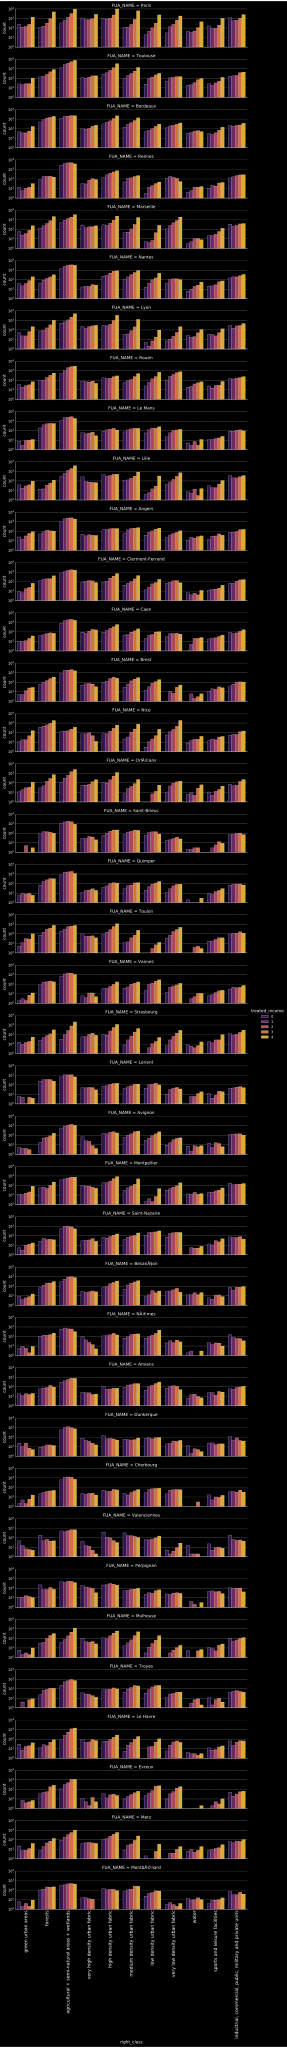

In [11]:
with plt.style.context('dark_background'):
    g=sns.catplot(x="right_class", hue="treated_income", row="FUA_NAME",
                data=idINSPIRE_geofull, kind="count",orient="h",palette="inferno",
                hue_order=[str(k) for k in range(NB_SES_CLASSES)],
                order=["green urban areas", "forests","agricultural + semi-natural areas + wetlands",
                       "very high density urban fabric",
                       "high density urban fabric", "medium density urban fabric", 
                       "low density urban fabric","very low density urban fabric",
                       "water","sports and leisure facilities",
                       "industrial, commercial, public, military and private units"],
                row_order = filtered_UAs.FUA_NAME,
                height=2, aspect=5);

    g.set(ylim=[1,1e4])
    g.set(yscale="log");
    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontdict={"fontsize":13})

In [15]:
plt.savefig?

In [12]:

g.savefig("/home/jlevyabi/cities.pdf",);

In [23]:
idINSPIRE2city = idINSPIRE_geofull[["idINSPIRE","FUA_NAME"]].drop_duplicates(subset="idINSPIRE")

In [29]:
idINSPIRE2city.to_csv(
"/warehouse/COMPLEXNET/jlevyabi/SATELSES/equirect_proj_test/cnes/data_files/outputs/AERIAL_esa_URBAN_ATLAS_FR/city_assoc.csv"
,index=False,)

In [3]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.balanced_image import BalancedImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model, load_model
import csv
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from keras.layers import Input
import multiprocessing
from joblib import Parallel, delayed
from skimage import io
from efficientnet import EfficientNetB0 as EfficientNet
import geopandas as gpd
import sys
sys.path.append("/warehouse/COMPLEXNET/jlevyabi/SATELSES/equirect_proj_test/cnes/python_files/aerial/")
from aerial_training_utils import generate_full_idINSPIRE, geographical_boundaries, my_preprocessor, fmeasure,recall,precision, fbeta_score
import argparse



Using TensorFlow backend.


In [4]:
# Global paths
BASE_DIR = "/warehouse/COMPLEXNET/jlevyabi/"
CENSUS_DIR = BASE_DIR + 'REPLICATE_LINGSES/data_files/census_data/'
UA_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
MODEL_OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/model_data/efficientnet_keras/2019_income_norm/"
BASE_AERDIR = BASE_DIR + "SATELSES/"
AERIAL_DIR= BASE_AERDIR + "equirect_proj_test/cnes/data_files/outputs/AERIAL_esa_URBAN_ATLAS_FR/"

# Global variables
NB_SES_CLASSES = 5
PATIENCE_BEFORE_STOPPING = 10 #8
PATIENCE_BEFORE_LOWERING_LR = 3 #1
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 25 #10 #16
IMG_SIZE = (800, 800)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 10 #7
INITIAL_LR = 1e-5 #1e-4
CPU_COUNT = multiprocessing.cpu_count()
CPU_FRAC = .7
CPU_USE = int(CPU_FRAC*CPU_COUNT)
ADRIAN_ALBERT_THRESHOLD = .25
INSEE_AREA = 200*200

print("Generating Income Classes")
full_im_df_ua = generate_full_idINSPIRE(UA_DIR, AERIAL_DIR, NB_SES_CLASSES, ADRIAN_ALBERT_THRESHOLD, INSEE_AREA, 
                                        old=False)
city_assoc = pd.read_csv(AERIAL_DIR + "city_assoc.csv")
full_im_df_ua = pd.merge(full_im_df_ua,city_assoc,on="idINSPIRE");
full_im_df_ua = full_im_df_ua[full_im_df_ua.FUA_NAME == "Paris"]


Generating Income Classes


In [5]:
MODEL_OUTPUT_DIR = MODEL_OUTPUT_DIR + "Paris" + "/"

In [64]:
val_min = lambda x : np.percentile(x,0)
val_min.__name__ = 'qmin'
val_per20 = lambda x : np.percentile(x,20)
val_per20.__name__ = 'q20'
val_per40 = lambda x : np.percentile(x,40)
val_per40.__name__ = 'q40'
val_per60 = lambda x : np.percentile(x,60)
val_per60.__name__ = 'q60'
val_per80 = lambda x : np.percentile(x,80)
val_per80.__name__ = 'q80'
val_max = lambda x : np.percentile(x,100)
val_max.__name__ = 'qmax'

ses_city_intervals = full_im_df_ua.groupby("FUA_NAME")[["income"]].agg(
    [val_min,val_per20,val_per40,val_per60,val_per80,val_max]
)
print(set(list(ses_city_intervals.index)))
df_cities = []
for city in list(ses_city_intervals.index):
    city_df_new = full_im_df_ua[full_im_df_ua.FUA_NAME==city]
    city_df_new.dropna(subset=["income"],inplace=True)
    income = city_df_new.income
    class_thresholds = ses_city_intervals.ix[city]["income"].values
    x_to_class = np.digitize(income,class_thresholds)
    x_to_class[x_to_class==np.max(x_to_class)] = NB_SES_CLASSES
    city_df_new["treated_citywise_income"] = [ str(y-1) for y in x_to_class ] 
    df_cities.append(city_df_new)

full_im_df_ua = gpd.GeoDataFrame(pd.concat(df_cities,axis=0),
                                            crs=full_im_df_ua.crs).sort_index()

print("Generating Generators")
full_im_df_ua = full_im_df_ua.sample(frac=1)
train_test_split = np.floor(full_im_df_ua.shape[0]*TRAIN_TEST_FRAC).astype(int)
train_im_df = full_im_df_ua.iloc[:train_test_split]
test_im_df = full_im_df_ua.iloc[train_test_split:]
train_image_count = int(train_test_split*(1-VAL_SPLIT))
val_image_count = int(train_test_split*VAL_SPLIT)
test_image_count = test_im_df.shape[0]

train_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor,
                                           horizontal_flip=True,validation_split=VAL_SPLIT,vertical_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor)

{'Paris'}
Generating Generators


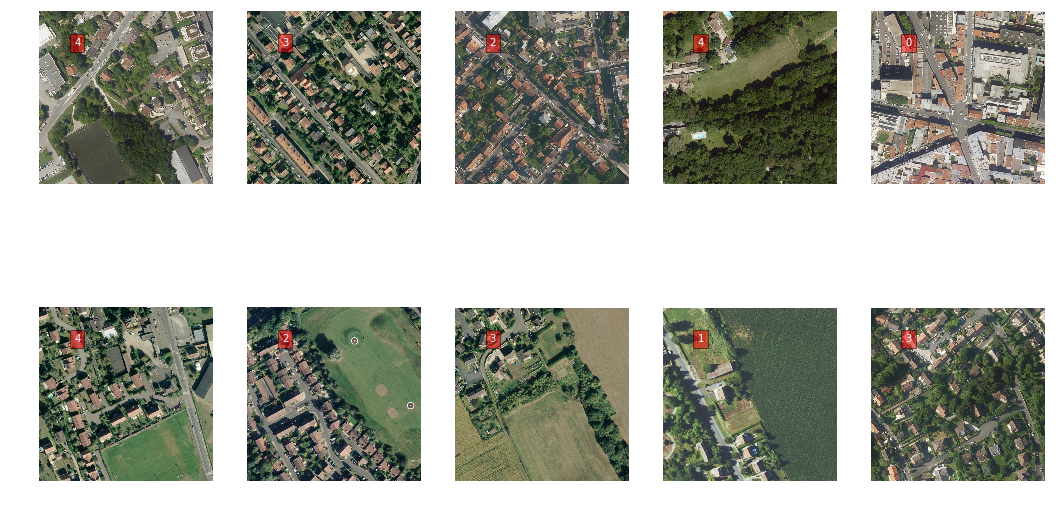

In [124]:
nb = 5
f,axes = plt.subplots(2,nb,figsize=(18,10));
for i in range(2*nb):
    axes[i//5,i%5].imshow(io.imread(AERIAL_DIR+train_im_df.iloc[i].path2im));
    axes[i//5,i%5].axis("off");
    axes[i//5,i%5].text(x=200,y=200,s=train_im_df.iloc[i].treated_citywise_income,#l_test[k],#
                                   color="white",
                                   bbox=dict(facecolor='red', alpha=0.5))

In [135]:
datagen = BalancedImageDataGenerator(horizontal_flip=False,vertical_flip=False,preprocessing_function=my_preprocessor,)


In [152]:
data_generator = datagen.flow_from_dataframe(
        train_im_df.iloc[:190],
        directory=AERIAL_DIR,
        x_col="path2im",
        y_col="treated_citywise_income",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=False,
        batch_size=10,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 190 images belonging to 5 classes.


In [ ]:
set

In [153]:
info=data_generator.next()

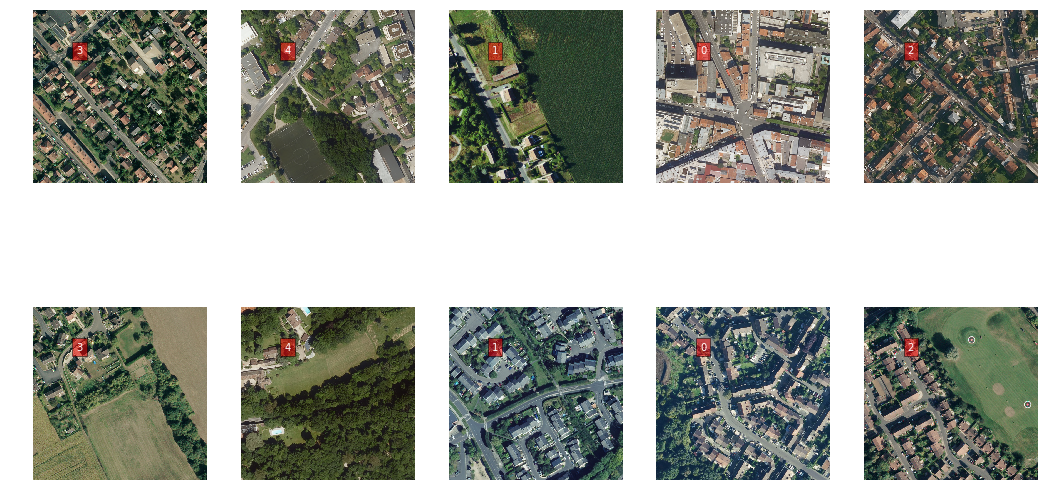

In [154]:
nb = 5
f,axes = plt.subplots(2,nb,figsize=(18,10));
for i in range(2*nb):
    axes[i//5,i%5].imshow(info[0][i]);
    lab = np.argmax(info[1][i])
    axes[i//5,i%5].axis("off");
    axes[i//5,i%5].text(x=200,y=200,s=lab,#l_test[k],#
                                   color="white",
                                   bbox=dict(facecolor='red', alpha=0.5))